In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from bluerecording.writeH5 import getSegmentMidpts,sort_electrode_names, getArraySpacing
%matplotlib ipympl

### Loads the values of the CSD coefficients

In [2]:
fname = 'electrodes/coeffs_highRes.h5'

f = h5py.File(fname)


### Loads the electrode positions from the H5 file containing the LFP coefficients

In [3]:
originalFile = h5py.File('electrodes/coeffs_highRes.h5')
electrodeNames = sort_electrode_names(originalFile['electrodes'].keys(),'S1nonbarrel_neurons')
allEpos = []
layers = []
for e in electrodeNames:
    allEpos.append( originalFile['electrodes'][str(e)]['position'][:] )
    layers.append( originalFile['electrodes'][str(e)]['layer'][()] )
allEpos = np.array(allEpos)
originalFile.close()
allEpos = allEpos[1:-1] # Removes the first and last electrodes, since taking the second derivative loses them
layers = layers[1:-1]

#### Prints the layer ids of the electrodes used in Figure 2c

In [4]:
ids = [10,25,50,75,90]
for i in ids:
    print(layers[i])

b'L6'
b'L6'
b'L5'
b'L3'
b'L2'


In [5]:
main_axis, arraySpacing = getArraySpacing(allEpos) # Gets array spacing and main axis of the electrode array

In [6]:
def distances_in_planar_coords(compartment_positions, electrodePos, main_axis):

    '''
    For a disk or plane perpendicular to main_axis, returns the axial and radial coordinates of each of the compartment positions
    '''

    from bluerecording.writeH5 import calculate_axial_vectors

    ### Projects compartment positions onto plane, containing the point electrodePos, normal to electrode array
    differenceVectors = compartment_positions.values - electrodePos[:,np.newaxis]

    axialDistances = np.matmul(differenceVectors.T,main_axis) # Size len(compartment_positions)x1

    return axialDistances

### Finds the node ids of the neurons in the central column

In [7]:
import bluepysnap as bp

In [8]:
c = bp.Simulation('electrodes/simulation_config.json')

RuntimeError: Path `electrodes/simulation_config.json` is not a file

In [16]:
hex0 = next(c.circuit.nodes.get('hex0',properties=['mtype']))

NameError: name 'c' is not defined

In [19]:
hex0Ids = np.array(hex0[1].loc['S1nonbarrel_neurons'].index)

In [20]:
np.save('hex0Ids.npy',hex0Ids)

In [7]:
hex0Ids = np.load('hex0Ids.npy')

### Reads the position files, selects neurons, and finds the CSD coefficient and distance from selected electrode for each segment

In [8]:
electrodeIndices = [10,25,50,75,90] # Sampling of electrodes across the column
allDistances = []
allCsdCoeffs = []
np.random.seed(2643)


for electrodeIdx in electrodeIndices:
    csdCoeffs = []
    distances = []

    numFiles = 0
    numNeurons = 0

    for dirpath, dirnames, filenames in os.walk('electrodes/positions'):
            for filename in filenames:
                
                file_path = os.path.join(dirpath, filename)
                positions = pd.read_pickle(file_path) # Loads pickle file containing segment positions for 1000 neurons
                
                node_ids = np.unique(np.array(list(positions.columns))[:,0]) # Reads node ids contained in this position file

                node_ids = node_ids[np.isin(node_ids,hex0Ids)] # Selects the node ids which are in the central column

                newNodeIds = np.random.choice(node_ids,int(0.05*len(node_ids)),replace=False) # Selects a 5% random sample of these

                newPos = getSegmentMidpts(positions[newNodeIds],newNodeIds) # Identifies geometric centers of each segment
    
                for ids in newNodeIds:

                    ### Finds indices in the weights file of the neural segments in each node id
    
                    nodeIndex = np.where(f['S1nonbarrel_neurons']['node_ids']==ids)[0][0]
    
                    offset = f['S1nonbarrel_neurons']['offsets'][nodeIndex]
                    offset1 = f['S1nonbarrel_neurons']['offsets'][nodeIndex+1]

                    ######
                    
                    distances.append(distances_in_planar_coords(newPos[ids],allEpos[electrodeIdx],main_axis)) # Vertical distance between segment and electrode
                    
                    csdCoeffs.append(f['electrodes']['S1nonbarrel_neurons']['scaling_factors'][offset:offset1,electrodeIdx]) # Coefficients for the electrode


    allCsdCoeffs.append(csdCoeffs)
    allDistances.append(distances)
    
            

In [ ]:
np.save('allCoeffs.npy',allCsdCoeffs)
np.save('allDistances.npy',allDistances)

In [10]:
allCsdCoeffs = np.load('allCoeffs.npy',allow_pickle=True)
allDistances = np.load('allDistances.npy',allow_pickle=True)

In [8]:
def analyticContribution(z,d,simulatedTotal):

    contribution = (np.abs(d-z)-2*np.abs(z)+np.abs(z+d))/d**2

    scaleFactor = np.sum(contribution)/simulatedTotal

    return contribution/scaleFactor

### Plots legends for Figure 2c in the paper

In [9]:
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, ListedColormap

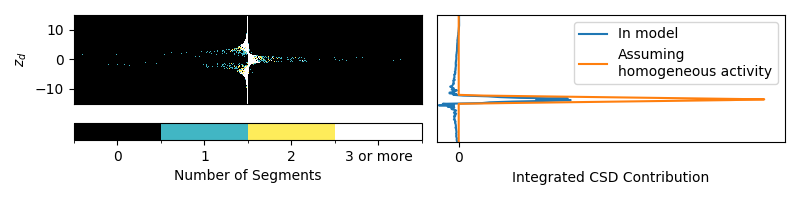

In [11]:
fig, axes = plt.subplots(1,2,figsize=(8,2))
    
# Iterates through electrodes backwards, since electrodes are stored from the bottom to the top of the column
distances = allDistances[2] 
csdCoeffs = allCsdCoeffs[2]

distances = np.array(distances)
csdCoeffs = np.array(csdCoeffs)

# Stacks distances and coefficients from each neuron, stored as separate lists, into a single contiguous numpy array
newDistances = distances[0]
for d in distances[1:]:
    newDistances = np.vstack((newDistances,d))

newcoeffs = csdCoeffs[0][:,np.newaxis]
for c in csdCoeffs[1:]:
    newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))

# Define 4 perceptually distinct colors (especially between first two)
colors = ['#000000', '#41b6c4', '#feec5a', '#ffffff']
cmap = ListedColormap(colors)

# Define bin boundaries for 4 bins
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors))

_, _, _, im = axes[0].hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=3,cmap=cmap,norm=norm) # Plots histogram (effectively a scatter plot) of CSD coefficients and vertical distances
cbar = plt.colorbar(im,ax=axes[0],orientation='horizontal',label='Number of Segments')
cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(['0', '1', '2', '3 or more'])
axes[0].set_xticks([])

    
axes[0].set_xlim([-5e-6,5e-6])

axes[0].set_ylabel('$z_d$')
axes[0].set_ylim([-15,15])


hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000]) # Gets bin and density values for the histogram
xvals = (xbins[1:]+xbins[:-1])/2
yvals = (ybins[1:]+ybins[:-1])/2

axes[1].plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals) # Integrates histogram over each distance bin
axes[1].plot(analyticContribution(yvals*20,20,np.sum(np.abs(newcoeffs))),yvals)
axes[1].set_ylim([-10,20])

axes[1].set_xlabel('Integrated CSD Contribution')
axes[1].set_xticks([0])
axes[1].legend(['In model','Assuming\nhomogeneous activity'])
    
axes[1].set_yticks([])
axes[1].set_xlim([-5e-5,75e-5])

plt.tight_layout()

plt.savefig('figures/wideHistogram.png')


### Plots Figure 2c in the paper

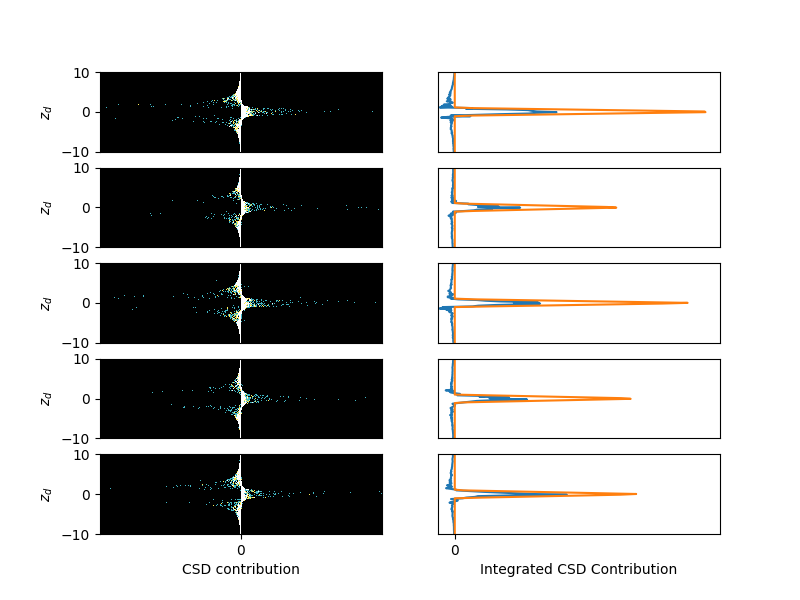

In [23]:

fig, axes = plt.subplots(5,2,figsize=(8,6))

for i in range(5):

    
    # Iterates through electrodes backwards, since electrodes are stored from the bottom to the top of the column
    distances = allDistances[4-i] 
    csdCoeffs = allCsdCoeffs[4-i]
    
    distances = np.array(distances)
    csdCoeffs = np.array(csdCoeffs)

    # Stacks distances and coefficients from each neuron, stored as separate lists, into a single contiguous numpy array
    newDistances = distances[0]
    for d in distances[1:]:
        newDistances = np.vstack((newDistances,d))
    
    newcoeffs = csdCoeffs[0][:,np.newaxis]
    for c in csdCoeffs[1:]:
        newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))

    # Define 4 perceptually distinct colors (especially between first two)
    colors = ['#000000', '#41b6c4', '#feec5a', '#ffffff']
    cmap = ListedColormap(colors)
    
    # Define bin boundaries for 4 bins
    bounds = [0, 1, 2, 3, 4]
    norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors))

    axes[i][0].hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=3,cmap=cmap,norm=norm) # Plots histogram (effectively a scatter plot) of CSD coefficients and vertical distances
    
    if i == 4:
        axes[i][0].set_xlabel('CSD contribution')
        axes[i][0].set_xticks([0])
    else:
        axes[i][0].set_xticks([])
        
    axes[i][0].set_xlim([-5e-6,5e-6])

    axes[i][0].set_ylabel('$z_d$')
    axes[i][0].set_ylim([-10,10])


    hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000]) # Gets bin and density values for the histogram
    xvals = (xbins[1:]+xbins[:-1])/2
    yvals = (ybins[1:]+ybins[:-1])/2

    axes[i][1].plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals) # Integrates histogram over each distance bin
    axes[i][1].plot(analyticContribution(yvals*20,20,np.sum(np.abs(newcoeffs))),yvals)

    axes[i][1].set_ylim([-10,10])

    if i == 4:
        axes[i][1].set_xlabel('Integrated CSD Contribution')
        axes[i][1].set_xticks([0])
    else:
        axes[i][1].set_xticks([])
        
    axes[i][1].set_yticks([])
    axes[i][1].set_xlim([-5e-5,80e-5])

plt.savefig('figures/histograms.png')

### Plots Figure 2a

In [11]:
def Cp(r_d,d,z_d): 

    return  (2/np.sqrt(r_d**2 + z_d**2) - 1/np.sqrt(r_d**2 + (z_d - 1)**2) - 1/np.sqrt(r_d**2 + (z_d + 1)**2))

In [25]:
r_max = 20
rn = np.linspace(-r_max,r_max,1000)

z_max = 10

z = np.linspace(-z_max,z_max,1000)

RR,ZZ = np.meshgrid(rn,z)
c = Cp(RR,20,ZZ)

#### The following several cells will calculate Dp, but they are not actually used as the computation takes too long

In [26]:
from sympy import symbols, sqrt, diff, Eq, solve, pi
from sympy.utilities.lambdify import lambdify

In [27]:
negativeContour = -3e-3
positiveContour = 4e-3

In [25]:
rd, zd, p = symbols('rd zd p', real=True)

f_expr = 2 / sqrt(rd**2 + zd**2) - 1 / sqrt(rd**2 + (zd + 1)**2) - 1 / sqrt(rd**2 + (zd - 1)**2) # This is equivalent to Cp, but defined with sympy
fp_expr = diff(f_expr, rd)  # df/drd

M = 10 # Maximum value of z_d for the plot of the density of the isocontour
N1 = 30 # Number of spaces
zd_vals = np.linspace(0, M, N1 + 1)

results_pos = []
results_neg = []

for zd_val in zd_vals:
    f_val_expr = f_expr.subs(zd, zd_val)
    fp_val_expr = fp_expr.subs(zd, zd_val)

    # Solve f(rd) == p for rd (you can choose a constant p, e.g., 0)
    p_val = positiveContour
    roots = solve(Eq(f_val_expr, p_val), rd)
    
    # Only take real solutions (SymPy handles reals, but double check)
    real_roots = [r.evalf() for r in roots if r.is_real and r.evalf() > 0]
    
    # Compute 2π * rd / fp for each root
    val = 0
    for r in real_roots:
        fp_val = fp_val_expr.subs(rd, r).evalf()
        if fp_val != 0:
            val += abs((2 * np.pi * float(r)) / float(fp_val))
    
    results_pos.append(val / 2)

    p_val = negativeContour
    roots = solve(Eq(f_val_expr, p_val), rd)
    
    # Only take real solutions (SymPy handles reals, but double check)
    real_roots = [r.evalf() for r in roots if r.is_real and r.evalf() > 0]
    
    # Compute 2π * rd / fp for each root
    val = 0
    for r in real_roots:
        fp_val = fp_val_expr.subs(rd, r).evalf()
        if fp_val != 0:
            val += abs((2 * np.pi * float(r)) / float(fp_val))
    
    results_neg.append(val / 2)


KeyboardInterrupt



In [ ]:
np.save('results.npy',[results_pos,results_neg])

#### In these cells, we copy and paste the values of Dp from Mathematica

In [16]:
zdResult = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, \
1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2., 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, \
2.8, 2.9, 3., 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4., 4.1, \
4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5., 5.1, 5.2, 5.3, 5.4, 5.5, \
5.6, 5.7, 5.8, 5.9, 6., 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, \
7., 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8., 8.1, 8.2, 8.3, \
8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9., 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, \
9.8, 9.9, 10])

In [17]:
densityPos = np.array([20777.7, 20777.3, 20776.5, 20775.3, 20774.1, 20773.5, 20774.4, \
20780.1, 20792., 20814.5, 20853., 20915.5, 21013.3, 21163.4, 21391.7, \
21740.2, 22280.7, 23148.1, 24628.8, 27470.7, 34588., 113944.])

In [18]:
densityNeg = np.array([0,0,0,0,0,0,0,2.20457, 6.29331, 14.0426, 27.0654, 47.2096, 76.4874, 116.986, \
170.765, 239.76, 325.687, 429.969, 553.688, 697.556, 861.914, \
1046.76, 1251.76, 1476.33, 1719.67, 1980.79, 2258.62, 2552., 2859.71, \
3180.58, 3513.41, 3857.08, 4210.49, 4572.62, 4942.52, 5319.29, \
5702.12, 6090.26, 6483.01, 6879.76, 7279.94, 7683.03, 8088.58, \
8496.18, 8905.43, 9316.02, 9727.64, 10140., 10552.9, 10966.1, \
11379.5, 11792.8, 12205.8, 12618.6, 13030.9, 13442.6, 13853.7, \
14264., 14673.5, 15082.2, 15489.9, 15896.7, 16302.4, 16707.1, \
17110.7, 17513.2, 17914.6, 18314.8, 18713.9, 19111.8, 19508.5, \
19904., 20298.3, 20691.5, 21083.4, 21474.1, 21863.6, 22252., 22639.1, \
23025.1, 23409.8, 23793.4, 24175.9, 24557.1, 24937.3, 25316.2, \
25694.1, 26070.8])

### Plots Figure 2a

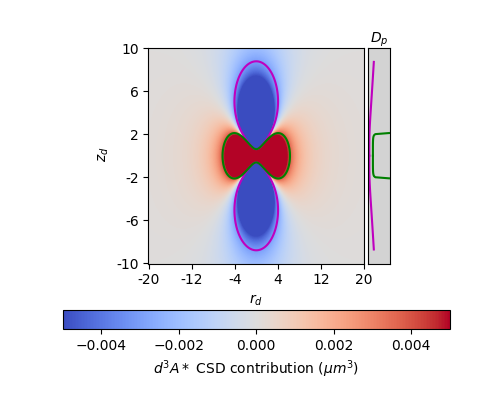

In [30]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
from matplotlib import colors
    
im = plt.imshow(c,norm=colors.TwoSlopeNorm(vcenter=0,vmin=-5e-3,vmax=5e-3),cmap='coolwarm',origin='lower')

desired_yticklabels = np.arange(-10,11,4)
ymin, ymax = -10, 10
array_width = 1000
yticks = ((desired_yticklabels + 10) / 20) * 999

ax.set_yticks(yticks)
ax.set_yticklabels(desired_yticklabels)

desired_xticklabels = np.arange(-20,21,8)
xmin, xmax = -20, 20
array_width = 1000
xticks = ((desired_xticklabels + 20) / 40) * 999

ax.set_xticks(xticks)
ax.set_xticklabels(desired_xticklabels)

plt.contour(c,[-3e-3,4e-3],colors=['m','green'])


plt.colorbar(im,label=r'$d^3A * $ CSD contribution ($\mu m^3$)',orientation='horizontal')
ax.set_ylabel(' $z_d$')
ax.set_xlabel('$r_d$')

z_vals = np.linspace(-10, 10, 1000)
f_vals = np.exp(-z_vals**2 / 10)  # Example function
ax_func = ax.inset_axes([1.02, 0, 0.1, 1], sharey=ax)  # [x0, y0, width, height]

ax_func.plot(densityPos, zdResult[:len(densityPos)]*50+500, color='green')
ax_func.plot(np.flip(densityPos), np.flip(zdResult[:len(densityPos)]*-50)+500, color='green')
ax_func.plot(densityNeg, zdResult[:len(densityNeg)]*50+500, color='m')
ax_func.plot(np.flip(densityNeg), np.flip(zdResult[:len(densityNeg)]*-50)+500, color='m')
# ax_func.set_xlim(0, np.max(f_vals))
ax_func.yaxis.set_visible(False)
ax_func.xaxis.tick_top()
ax_func.set_xticks([])
ax_func.set_facecolor('lightgray')
ax_func.set_xlabel('$D_p$')
ax_func.xaxis.set_label_position('top')
plt.savefig('figures/Cp.png')